In [4]:
%matplotlib inline
import pandas as pd
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import glob
import numpy as np
import pickle
import shap
from collections import Counter

In [5]:
mgus_list_aiims = pd.read_csv('/home/vivek/aiims_data_processing/top250_feature_matrix/mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_aiims = pd.read_csv('/home/vivek/aiims_data_processing/top250_feature_matrix/mm_common_genes.csv')['Sample'].values.tolist()
mgus_list_ega = pd.read_csv('/home/vivek/ega_data_1901/top250_feature_matrix/mgus_common_genes.csv')['Sample'].values.tolist()
mm_list_mmrf = pd.read_csv('/home/vivek/mmrf_data/mmrf_variant_callers/hg19/top250_feature_matrix/mm_common_genes.csv')['Sample'].values.tolist()

total_mm_list = mm_list_aiims + mm_list_mmrf
total_mgus_list = mgus_list_ega + mgus_list_aiims
total_list = total_mm_list + total_mgus_list

genelist = open('total_genes_qallsubs_filtered.txt').read().split('\n')[:-1]

# Average Previously reported genes in datasets

In [6]:
samplewise_summary = pd.DataFrame()
sample_list, dataset, gene_types, no_genes = [], [], [], []
last_shap_score = []
disease = []
gene_type = ["OG","TSG","ODG","AG"] #"TAG","DG","TDG"
for sam in tqdm(glob.glob("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/*.csv")):
    sam_name = sam.split('/')[-1].split('.')[0][:-14]
    df = pd.read_csv(sam)
    df = df.head(n=100)
    last_shap = df.iloc[-1,1]
    for g in gene_type:
        if sam_name in total_mm_list:
            disease.append("MM")
        else:
            disease.append("MGUS")
        last_shap_score.append(last_shap)
        sample_list.append(sam_name)
        if 'MMRF' in sam_name:
            dataset.append("MMRF")
        elif 'CR' in sam_name:
            dataset.append("EGA")
        else:
            dataset.append("AIIMS")
        gene_types.append(g)
        # if g == "DG":
        #     no_genes.append(df.iloc[-1,3])
        if g == "OG":
            no_genes.append(df.iloc[-1,4])
        elif g == "TSG":
            no_genes.append(df.iloc[-1,5])
        elif g == "ODG":
            no_genes.append(df.iloc[-1,6])
        # elif g == "TDG":
        #     no_genes.append(df.iloc[-1,7])
        elif g == "AG":
            no_genes.append(df.iloc[-1,8] + df.iloc[-1,9])
        # elif g == "TAG":
        #     no_genes.append(df.iloc[-1,9])
    
samplewise_summary["Sample"] = sample_list
samplewise_summary["Dataset"] = dataset
samplewise_summary["Disease"] = disease
samplewise_summary["Last_shap"] = last_shap_score
samplewise_summary["Gene_type"] = gene_types
samplewise_summary["No_genes"] = no_genes
# samplewise_summary.to_excel("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/samplewise_summary_v2.xlsx", index=False)
samplewise_summary.head()

100%|██████████| 1163/1163 [00:02<00:00, 519.77it/s]


,Sample,Dataset,Disease,Last_shap,Gene_type,No_genes
0,SM0266,AIIMS,MM,0.011698,OG,1
1,SM0266,AIIMS,MM,0.011698,TSG,6
2,SM0266,AIIMS,MM,0.011698,ODG,0
3,SM0266,AIIMS,MM,0.011698,AG,2
4,MMRF_1520_1_BM_CD138pos,MMRF,MM,-0.020466,OG,7


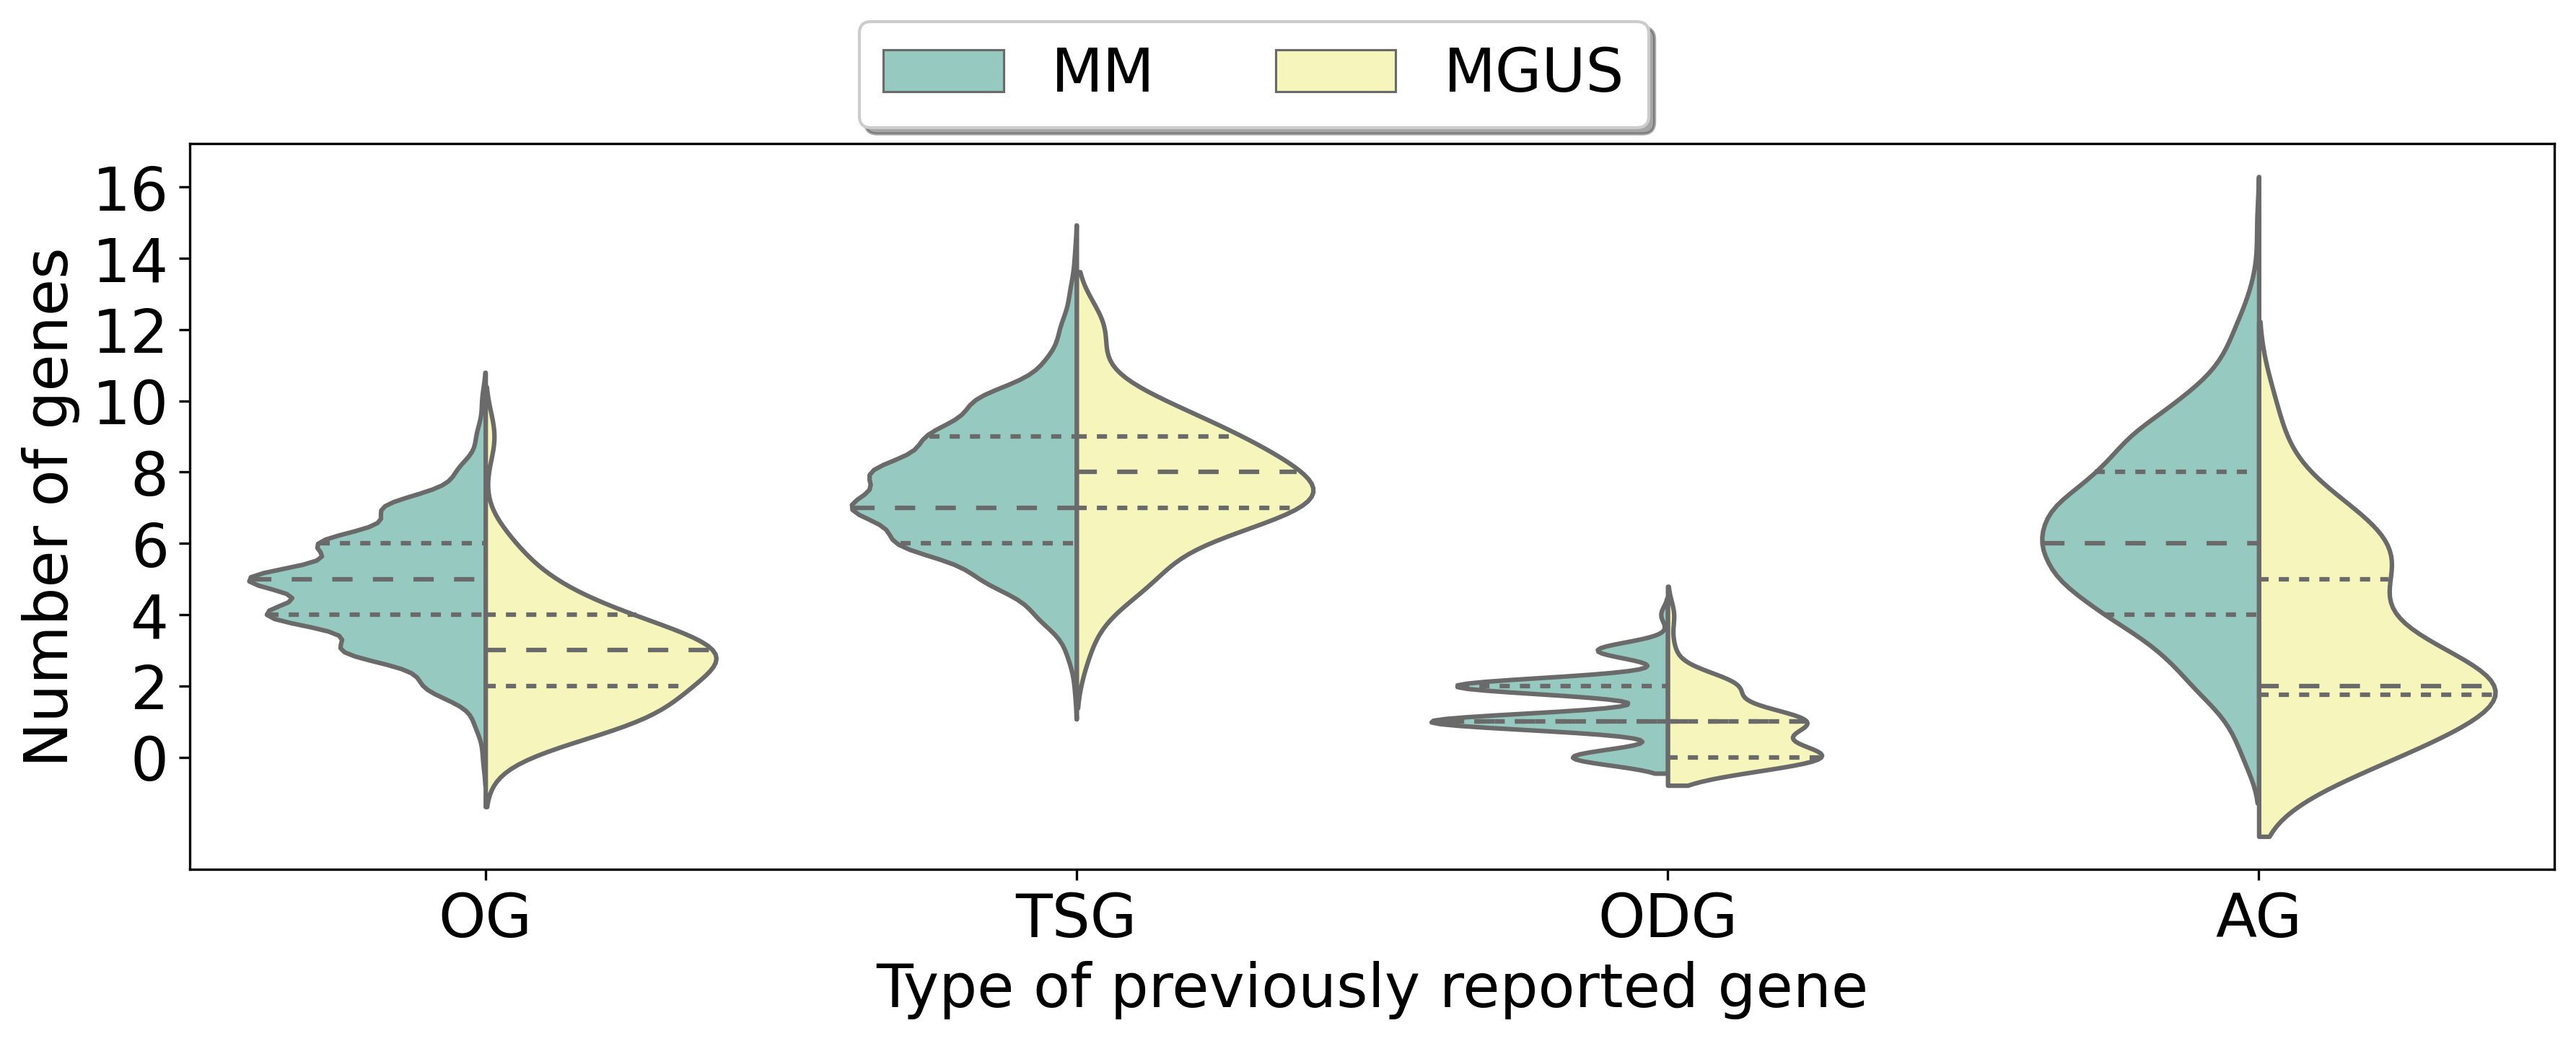

In [25]:
fig, ax = plt.subplots(figsize=(12,5), dpi=300)
sns_dict = sns.violinplot(x="Gene_type", y="No_genes", hue="Disease", data=samplewise_summary, palette="Set3", inner="quartile", split=True)
plt.xticks(fontsize = 20)
plt.yticks([0,2,4,6,8,10,12,14,16],fontsize = 20)
plt.xlabel("Type of previously reported gene",fontsize = 20)
plt.ylabel("Number of genes", fontsize = 20)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.21), ncol=3, fancybox=True, shadow=True,fontsize=20)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/All_samplewise_summary_v2.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/All_samplewise_summary_v2.svg",dpi=300)
plt.show()

In [18]:
def filter_df(df, col1, col2, attr1, attr2):
    return df.query(col1 + '.str.startswith("'+ attr1 +'") and '+ col2 + '.str.startswith("' + attr2 + '")')

In [29]:
mm_og = filter_df(samplewise_summary, "Gene_type", "Disease", "OG","MM")["No_genes"].values.tolist()
mm_odg = filter_df(samplewise_summary, "Gene_type", "Disease", "ODG","MM")["No_genes"].values.tolist()
mm_ag = filter_df(samplewise_summary, "Gene_type", "Disease", "AG","MM")["No_genes"].values.tolist()
mm_tsg = filter_df(samplewise_summary, "Gene_type", "Disease", "TSG","MM")["No_genes"].values.tolist()

mgus_og = filter_df(samplewise_summary, "Gene_type", "Disease", "OG","MGUS")["No_genes"].values.tolist()
mgus_odg = filter_df(samplewise_summary, "Gene_type", "Disease", "ODG","MGUS")["No_genes"].values.tolist()
mgus_ag = filter_df(samplewise_summary, "Gene_type", "Disease", "AG","MGUS")["No_genes"].values.tolist()
mgus_tsg = filter_df(samplewise_summary, "Gene_type", "Disease", "TSG","MGUS")["No_genes"].values.tolist()
mm_mgus_prev_genes = [mm_og, mm_tsg, mm_odg, mm_ag, mgus_og, mgus_tsg, mgus_odg, mgus_ag]
print([np.median(i) for i in mm_mgus_prev_genes])
og_ranksum = ranksums(mm_og, mgus_og)[1]
odg_ranksum = ranksums(mm_odg, mgus_odg)[1]
tsg_ranksum = ranksums(mm_tsg, mgus_tsg)[1]
ag_ranksum = ranksums(mm_ag, mgus_ag)[1]

print(og_ranksum, odg_ranksum, tsg_ranksum, ag_ranksum)

[5.0, 7.0, 1.0, 6.0, 3.0, 8.0, 1.0, 2.0]
2.016556824670141e-16 2.4228865867414935e-06 0.45497970374822894 3.209007791010439e-14


In [2]:
def filter_df(df, col1, col2, col3, attr1, attr2, attr3):
    return df.query(col1 + '.str.startswith("'+ attr1 +'") and '+ col2 + '.str.startswith("' + attr2 + '") and '+ col3 + '.str.startswith("' + attr3 + '")')

In [32]:
# np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MM")["No_genes"])
medians = [np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "TSG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "ODG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "AG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "OG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "TSG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "ODG", "MM")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "AG", "MM")["No_genes"])]
print(medians)

[5.0, 7.0, 1.0, 6.0, 5.0, 7.0, 1.0, 6.0]


In [7]:
aiims_og = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MM")["No_genes"].values.tolist()
aiims_odg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "ODG", "MM")["No_genes"].values.tolist()
aiims_tsg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "TSG", "MM")["No_genes"].values.tolist()
aiims_ag = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "AG", "MM")["No_genes"].values.tolist()

mmrf_og = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "OG", "MM")["No_genes"].values.tolist()
mmrf_odg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "ODG", "MM")["No_genes"].values.tolist()
mmrf_tsg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "TSG", "MM")["No_genes"].values.tolist()
mmrf_ag = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "MMRF", "AG", "MM")["No_genes"].values.tolist()

mm_mgus_prev_genes = [aiims_og, aiims_tsg, aiims_odg, aiims_ag, mmrf_og, mmrf_tsg, mmrf_odg, mmrf_ag]
print([np.median(i) for i in mm_mgus_prev_genes])
og_ranksum = ranksums(aiims_og, mmrf_og)[1]
odg_ranksum = ranksums(aiims_odg, mmrf_odg)[1]
tsg_ranksum = ranksums(aiims_tsg, mmrf_tsg)[1]
ag_ranksum = ranksums(aiims_ag, mmrf_ag)[1]

print(og_ranksum, odg_ranksum, tsg_ranksum, ag_ranksum)

[5.0, 7.0, 1.0, 6.0, 5.0, 7.0, 1.0, 6.0]
0.1808696379530026 0.3830207394325248 0.753333767013964 0.4382227395189755


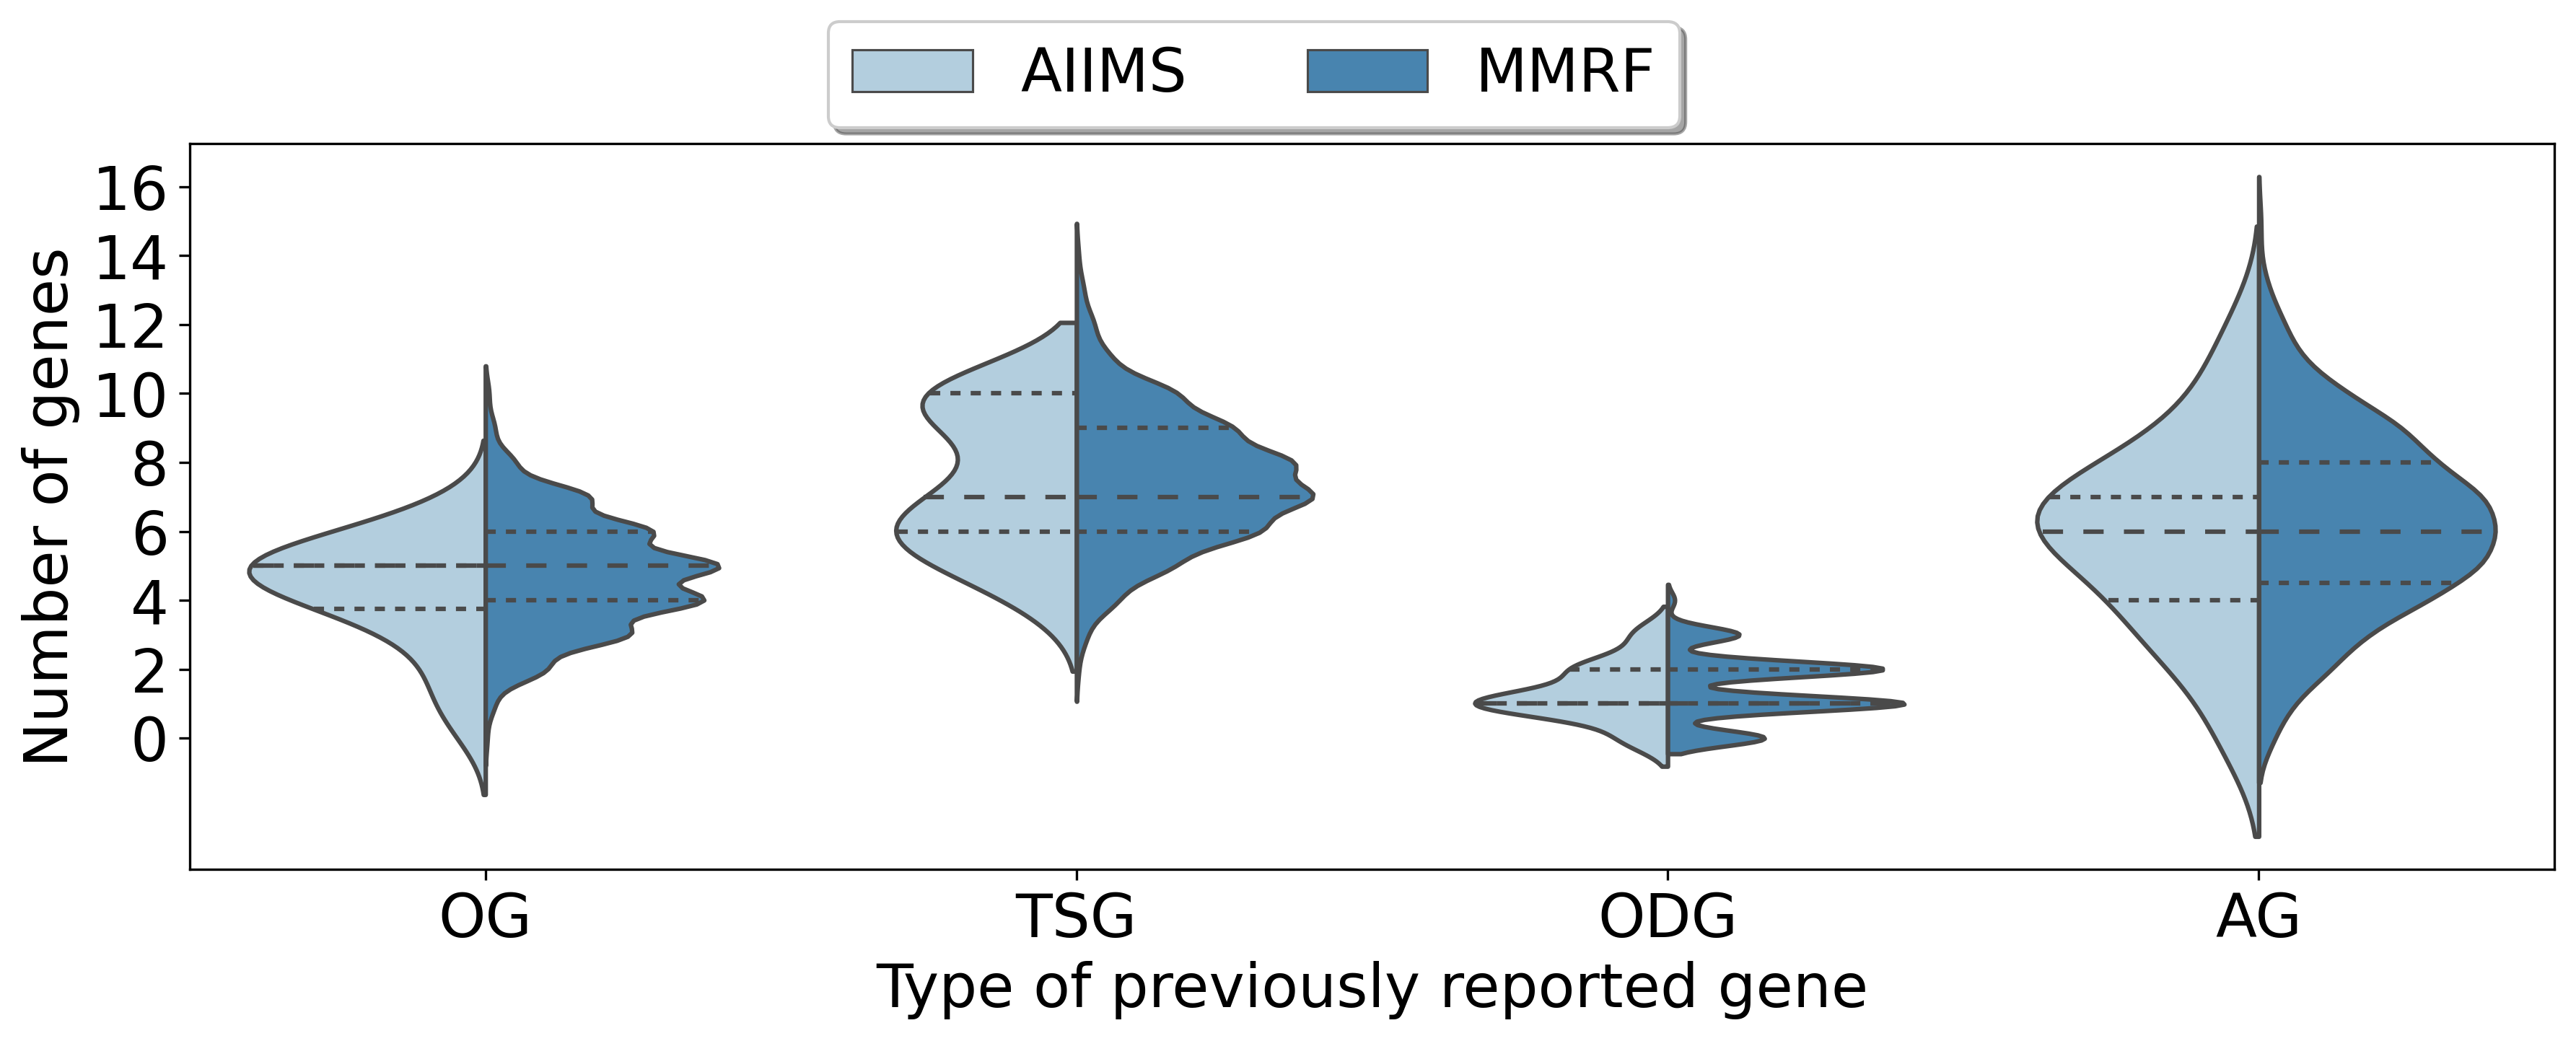

In [26]:
samplewise_summary_mm = samplewise_summary[samplewise_summary['Disease'] == "MM"]
fig, ax = plt.subplots(figsize=(12,5),dpi=300)
sns_dict = sns.violinplot(x="Gene_type", y="No_genes", hue="Dataset", data=samplewise_summary_mm, palette="Blues", inner="quartile", split=True)
plt.xticks(fontsize = 20)
plt.yticks([0,2,4,6,8,10,12,14,16],fontsize = 20)
plt.xlabel("Type of previously reported gene",fontsize = 20)
plt.ylabel("Number of genes", fontsize = 20)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.21), ncol=3, fancybox=True, shadow=True,fontsize=20)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MM_samplewise_summary_v3.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MM_samplewise_summary_v3.svg",dpi=300)
plt.show()

In [8]:
avg_mean = np.mean([np.abs(i) for i in samplewise_summary_mm["Last_shap"].values.tolist()])
avg_std = np.std([np.abs(i) for i in samplewise_summary_mm["Last_shap"].values.tolist()])
print(f'The mean of absolute SHAP scores of top 100 genes of MM Samples:{avg_mean}')
print(f'The standard deviation of absolute SHAP scores of top 100 genes of MM Samples:{avg_std}')

The mean of absolute SHAP scores of top 100 genes of MM Samples:0.01745750062319257
The standard deviation of absolute SHAP scores of top 100 genes of MM Samples:0.003707585617258757


In [34]:
# np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MM")["No_genes"])
medians = [np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "TSG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "ODG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "AG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "OG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "TSG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "ODG", "MGUS")["No_genes"]),
           np.median(filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "AG", "MGUS")["No_genes"])]
print(medians)

[3.0, 8.0, 1.0, 5.0, 2.0, 7.0, 0.0, 2.0]


In [8]:
aiims_og = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "OG", "MGUS")["No_genes"].values.tolist()
aiims_odg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "ODG", "MGUS")["No_genes"].values.tolist()
aiims_tsg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "TSG", "MGUS")["No_genes"].values.tolist()
aiims_ag = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "AIIMS", "AG", "MGUS")["No_genes"].values.tolist()

ega_og = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "OG", "MGUS")["No_genes"].values.tolist()
ega_odg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "ODG", "MGUS")["No_genes"].values.tolist()
ega_tsg = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "TSG", "MGUS")["No_genes"].values.tolist()
ega_ag = filter_df(samplewise_summary, "Dataset", "Gene_type", "Disease", "EGA", "AG", "MGUS")["No_genes"].values.tolist()

mm_mgus_prev_genes = [aiims_og, aiims_tsg, aiims_odg, aiims_ag, ega_og, ega_tsg, ega_odg, ega_ag]
print([np.median(i) for i in mm_mgus_prev_genes])
og_ranksum = ranksums(aiims_og, ega_og)[1]
odg_ranksum = ranksums(aiims_odg, ega_odg)[1]
tsg_ranksum = ranksums(aiims_tsg, ega_tsg)[1]
ag_ranksum = ranksums(aiims_ag, ega_ag)[1]

print(og_ranksum, odg_ranksum, tsg_ranksum, ag_ranksum)

[3.0, 8.0, 1.0, 5.0, 2.0, 7.0, 0.0, 2.0]
0.0001975288319572634 0.04253568237260168 0.2780544665861725 9.190847077970374e-06


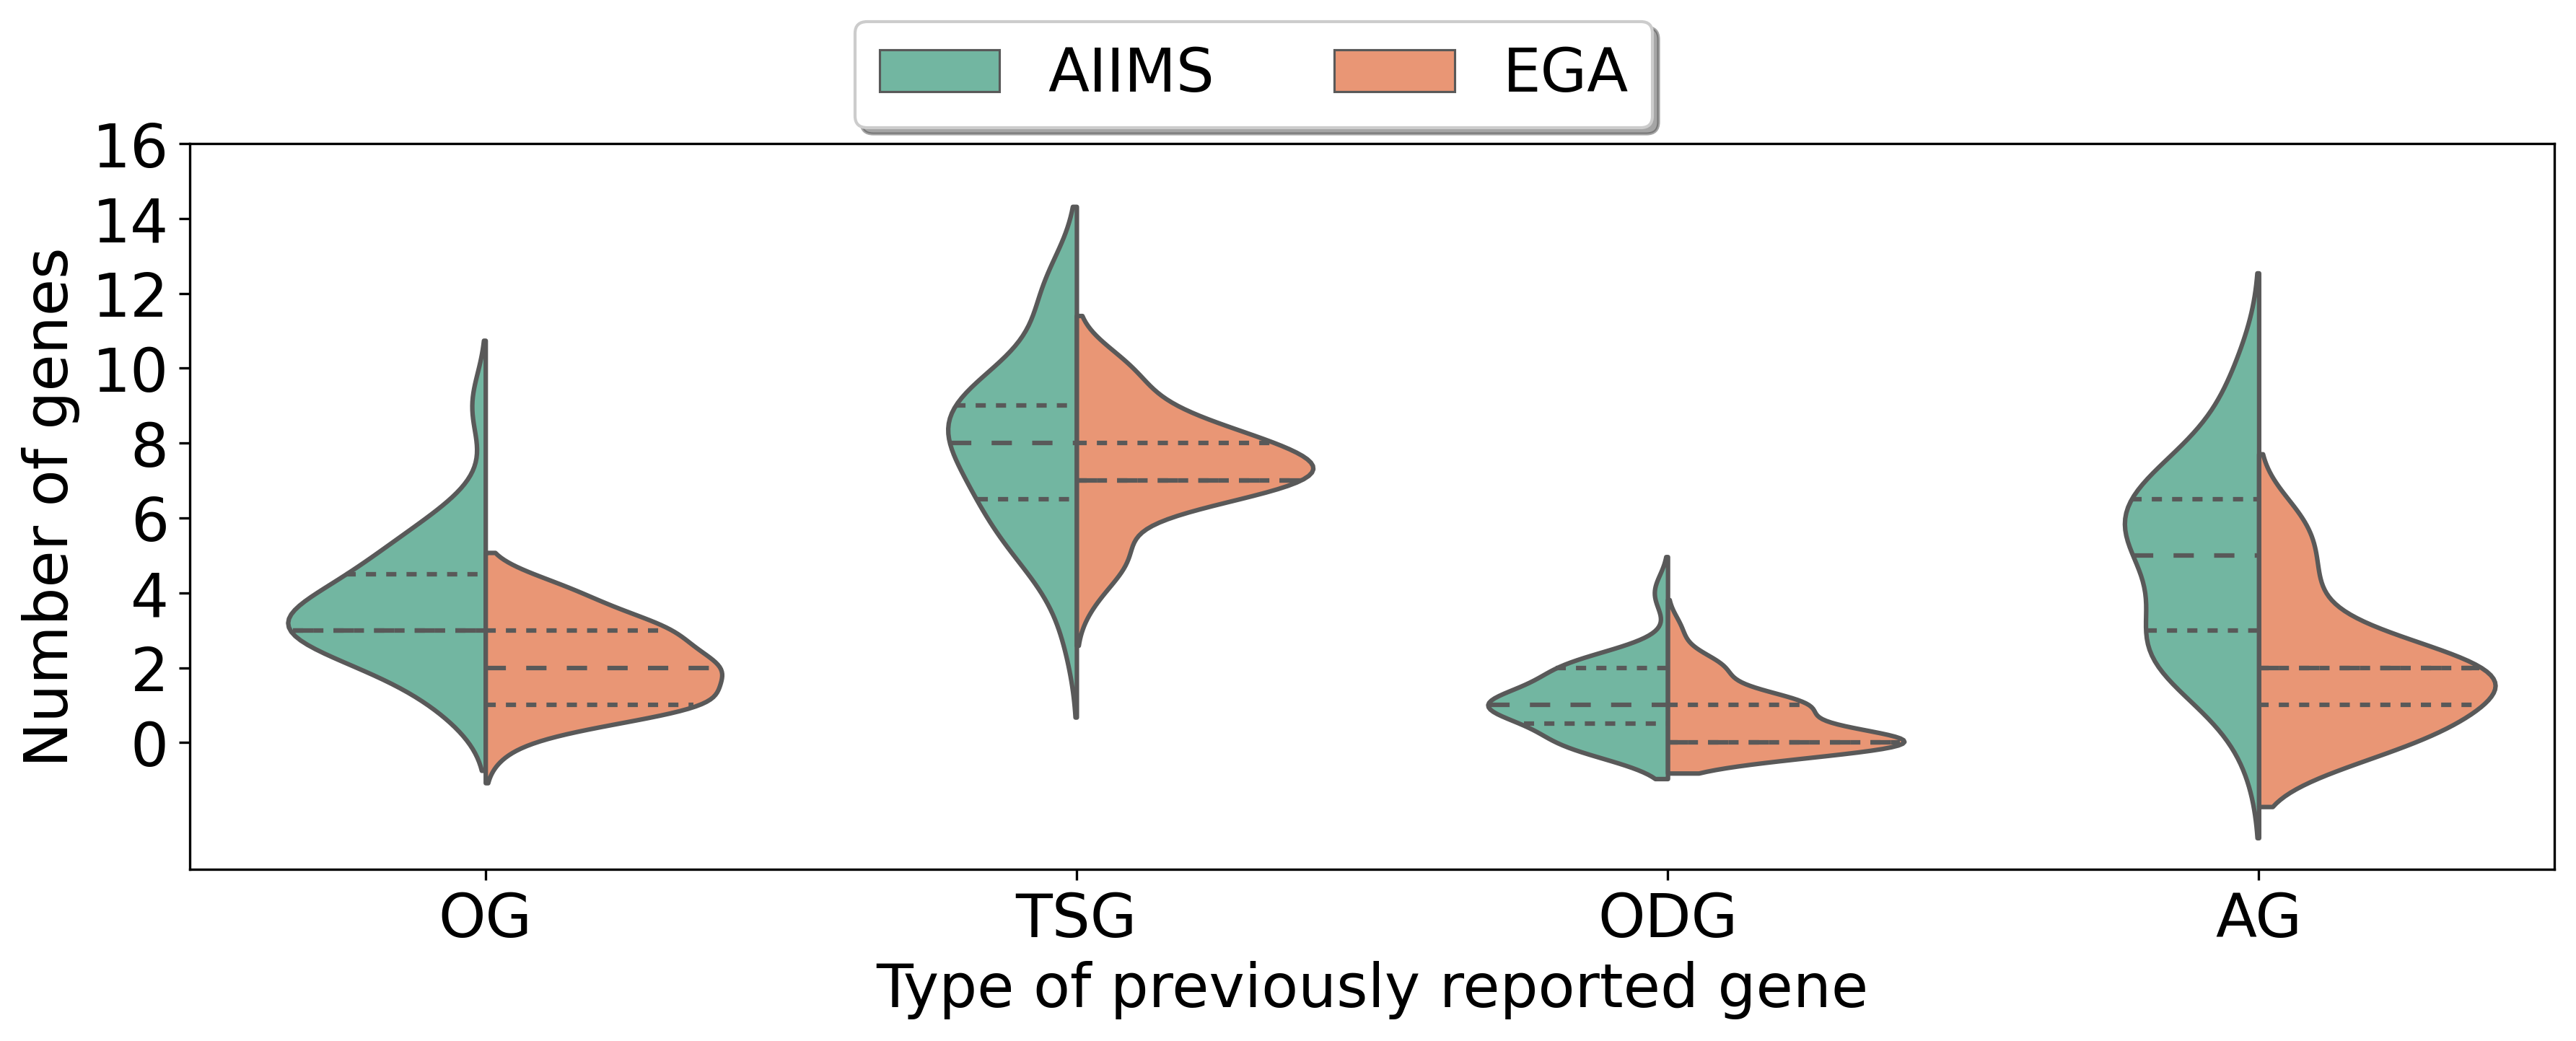

In [35]:
samplewise_summary_mgus = samplewise_summary[samplewise_summary['Disease'] == "MGUS"]
fig, ax = plt.subplots(figsize=(12,5),dpi=300)
sns.violinplot(x="Gene_type", y="No_genes", hue="Dataset", data=samplewise_summary_mgus, palette="Set2", inner="quartile", split=True)
plt.xticks(fontsize = 20)
plt.yticks([0,2,4,6,8,10,12,14,16],fontsize = 20)
plt.xlabel("Type of previously reported gene",fontsize = 20)
plt.ylabel("Number of genes", fontsize = 20)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.21), ncol=3, fancybox=True, shadow=True,fontsize=20)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MGUS_samplewise_summary_v3.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MGUS_samplewise_summary_v3.svg",dpi=300)
plt.show()

In [10]:
avg_mean = np.mean([np.abs(i) for i in samplewise_summary_mgus["Last_shap"].values.tolist()])
avg_std = np.std([np.abs(i) for i in samplewise_summary_mgus["Last_shap"].values.tolist()])
print(f'The mean of absolute SHAP scores of top 100 genes of MGUS Samples:{avg_mean}')
print(f'The standard deviation of absolute SHAP scores of top 100 genes of MGUS Samples:{avg_std}')

The mean of absolute SHAP scores of top 100 genes of MGUS Samples:0.017178952122647764
The standard deviation of absolute SHAP scores of top 100 genes of MGUS Samples:0.004063340369347872


# Box plot for shap scores of genomic features

In [13]:
with open('Feb_25_2022/shap_values.pickle','rb') as handle:
    shap_values = pickle.load(handle)

In [14]:
shap_values_fold1 = shap_values['fold1']
shap_values_fold2 = shap_values['fold2']
shap_values_fold3 = shap_values['fold3']
shap_values_fold4 = shap_values['fold4']
shap_values_fold5 = shap_values['fold5']

In [15]:
def get_shap_samplewise(sample, shap_values_foldno):
    if sample in shap_values_foldno.keys():
        if sample in total_mm_list: #for MM sample
            shap_values = shap_values_foldno[sample]['shap_values'][0]
        else: # For MGUS Sample
            shap_values = shap_values_foldno[sample]['shap_values'][1]
    else:
        print(f'The sample was not correctly mapped in {shap_values_foldno}')
        shap_values = []
    
    return shap_values

In [16]:
def get_shap_samplewise2(sample):
    correct_cls_dict = {}
    if sample in shap_values_fold1.keys():
        correct_cls_dict['fold1'] = {'shap_values':get_shap_samplewise(sample,shap_values_fold1)}
        
    if sample in shap_values_fold2.keys():
        correct_cls_dict['fold2'] = {'shap_values':get_shap_samplewise(sample,shap_values_fold2)}
        
    if sample in shap_values_fold3.keys():
        correct_cls_dict['fold3'] = {'shap_values':get_shap_samplewise(sample,shap_values_fold3)}
        
    if sample in shap_values_fold4.keys():
        correct_cls_dict['fold4'] = {'shap_values':get_shap_samplewise(sample,shap_values_fold4)}
        
    if sample in shap_values_fold5.keys():
        correct_cls_dict['fold5'] = {'shap_values':get_shap_samplewise(sample,shap_values_fold5)}
        
    return correct_cls_dict

In [17]:
def dominent_shap_for_each_fold(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(824,28)
    negative_shap = [(sum(j[j<0])) for j in ashap]
    positive_shap = [(sum(j[j>0])) for j in ashap]
    dominent_shap = [i if np.abs(i)>j else j for (i,j) in zip(negative_shap,positive_shap)]
    return dominent_shap

In [18]:
def features_for_dominent_shap(shap_dict, foldno):
    ashap = shap_dict[foldno]['shap_values'].reshape(824,28)
    dominent_shap = dominent_shap_for_each_fold(shap_dict, foldno)
    shap_for_each_feature = []
    for dom in dominent_shap:
        shap_index = dominent_shap.index(dom)
        shap_for_each_feature.append([list(ashap[shap_index])])
    return dominent_shap, shap_for_each_feature

In [19]:
def get_feature_mat(sample):
    if 'MMRF' in sample:
        path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/mmrf'
    elif 'CR-MGUS' in sample:
        path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/ega'
    else:
        path = path = '/home/vivek/extended_feature_matrix/824_genes_grouped_feature_matrix/aiims'
    df = pd.read_csv(os.path.join(path,sample),index_col=0, header=0)
    return df

In [20]:
correctly_mapped_samples = list(set(list(shap_values_fold1.keys()) + list(shap_values_fold2.keys()) + list(shap_values_fold3.keys()) + list(shap_values_fold4.keys()) + list(shap_values_fold5.keys())))
# sample = correctly_mapped_samples[0]
def get_shap_features(sample):
    sample_shap = get_shap_samplewise2(sample)
    dominent_shap_dict = {}
    best_shap_values = []
    raw_feature_vals = []
    shap_each_feat = []
#     print(f'Checking {sample} shap values in {len(sample_shap.keys())}.')
    for k,v in sample_shap.items():
        shap_out1, shap_out2 = features_for_dominent_shap(sample_shap, k)
        dominent_shap_dict[k] = {}
        dominent_shap_dict[k]['dominent_shap'] = shap_out1
        dominent_shap_dict[k]['shap_for_each_feature'] = shap_out2

    for j in range(824):
        shap_across_folds = [dominent_shap_dict[k]['dominent_shap'][j] for k in dominent_shap_dict.keys()]
        shap_each_feature_across_folds = [dominent_shap_dict[k]['shap_for_each_feature'][j] for k in dominent_shap_dict.keys()]
        try:
            idx = shap_across_folds.index(max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
        except: 
            idx = shap_across_folds.index(-max(np.abs(shap_across_folds)))
            best_shap_values.append(shap_across_folds[idx])
            shap_each_feat.append(shap_each_feature_across_folds[idx])
            
    return best_shap_values, shap_each_feat

In [21]:
feature_list = ['total_counts',
                    
                'syn_total',
                'syn_vaf_max', 'syn_vaf_median',
                'syn_vaf_mean', 'syn_vaf_sd', 'syn_dp_max',
                'syn_dp_median', 'syn_dp_mean', 'syn_dp_sd', 
                
                'non_syn_total', 
                'non_syn_vaf_max', 'non_syn_vaf_median', 
                'non_syn_vaf_mean', 'non_syn_vaf_sd', 'non_syn_dp_max',
                'non_syn_dp_median', 'non_syn_dp_mean', 'non_syn_dp_sd',
                
                'others_total',
                'others_vaf_max', 'others_vaf_median',
                'others_vaf_mean', 'others_vaf_sd', 
                'others_dp_max', 'others_dp_median', 
                'others_dp_mean', 'others_dp_sd',
                ]

In [22]:
def get_shap_df(sam):
    _,dom_shap_for_each_feature = get_shap_features(sam)
    feat_mat = get_feature_mat(sam)
    feat_names = feat_mat.columns
    index_names = feat_mat.index
    shap_df = pd.DataFrame(np.array(dom_shap_for_each_feature).reshape(824,28),
                        index=index_names,
                        columns= feat_names)
    shap_df = shap_df[feat_mat['total_counts']!=0]
    return shap_df

In [23]:
samplewise_feature_summary = pd.DataFrame()
sample_list, dataset, feat_names, avg_shap = [], [], [], []
disease = []

for sam in tqdm(glob.glob("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/*.csv")):
    sam_name = sam.split('/')[-1].split('.')[0][:-14]
    df = get_shap_df(sam_name+'.csv')
    for f_idx in range(len(feature_list)):
        if 'total' in feature_list[f_idx] or 'median' in feature_list[f_idx]:
            if sam_name in total_mm_list:
                disease.append("MM")
            else:
                disease.append("MGUS")
            sample_list.append(sam_name)
            if 'MMRF' in sam_name:
                dataset.append("MMRF")
            elif 'CR' in sam_name:
                dataset.append("EGA")
            else:
                dataset.append("AIIMS")
            feat_names.append(feature_list[f_idx])
            avg_shap.append(df[feature_list[f_idx]].mean())
    
samplewise_feature_summary["Sample"] = sample_list
samplewise_feature_summary["Dataset"] = dataset
samplewise_feature_summary["Disease"] = disease
samplewise_feature_summary["feature_name"] = feat_names
samplewise_feature_summary["avg_shap"] = [np.abs(i) for i in avg_shap]
samplewise_feature_summary.to_excel("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/samplewise_features_summary_v2.xlsx", index=False)
samplewise_feature_summary.head()

100%|██████████| 1163/1163 [01:55<00:00, 10.09it/s]


,Sample,Dataset,Disease,feature_name,avg_shap
0,SM0266,AIIMS,MM,total_counts,0.000691
1,SM0266,AIIMS,MM,syn_total,0.000383
2,SM0266,AIIMS,MM,syn_vaf_median,0.000288
3,SM0266,AIIMS,MM,syn_dp_median,0.000373
4,SM0266,AIIMS,MM,non_syn_total,0.000153


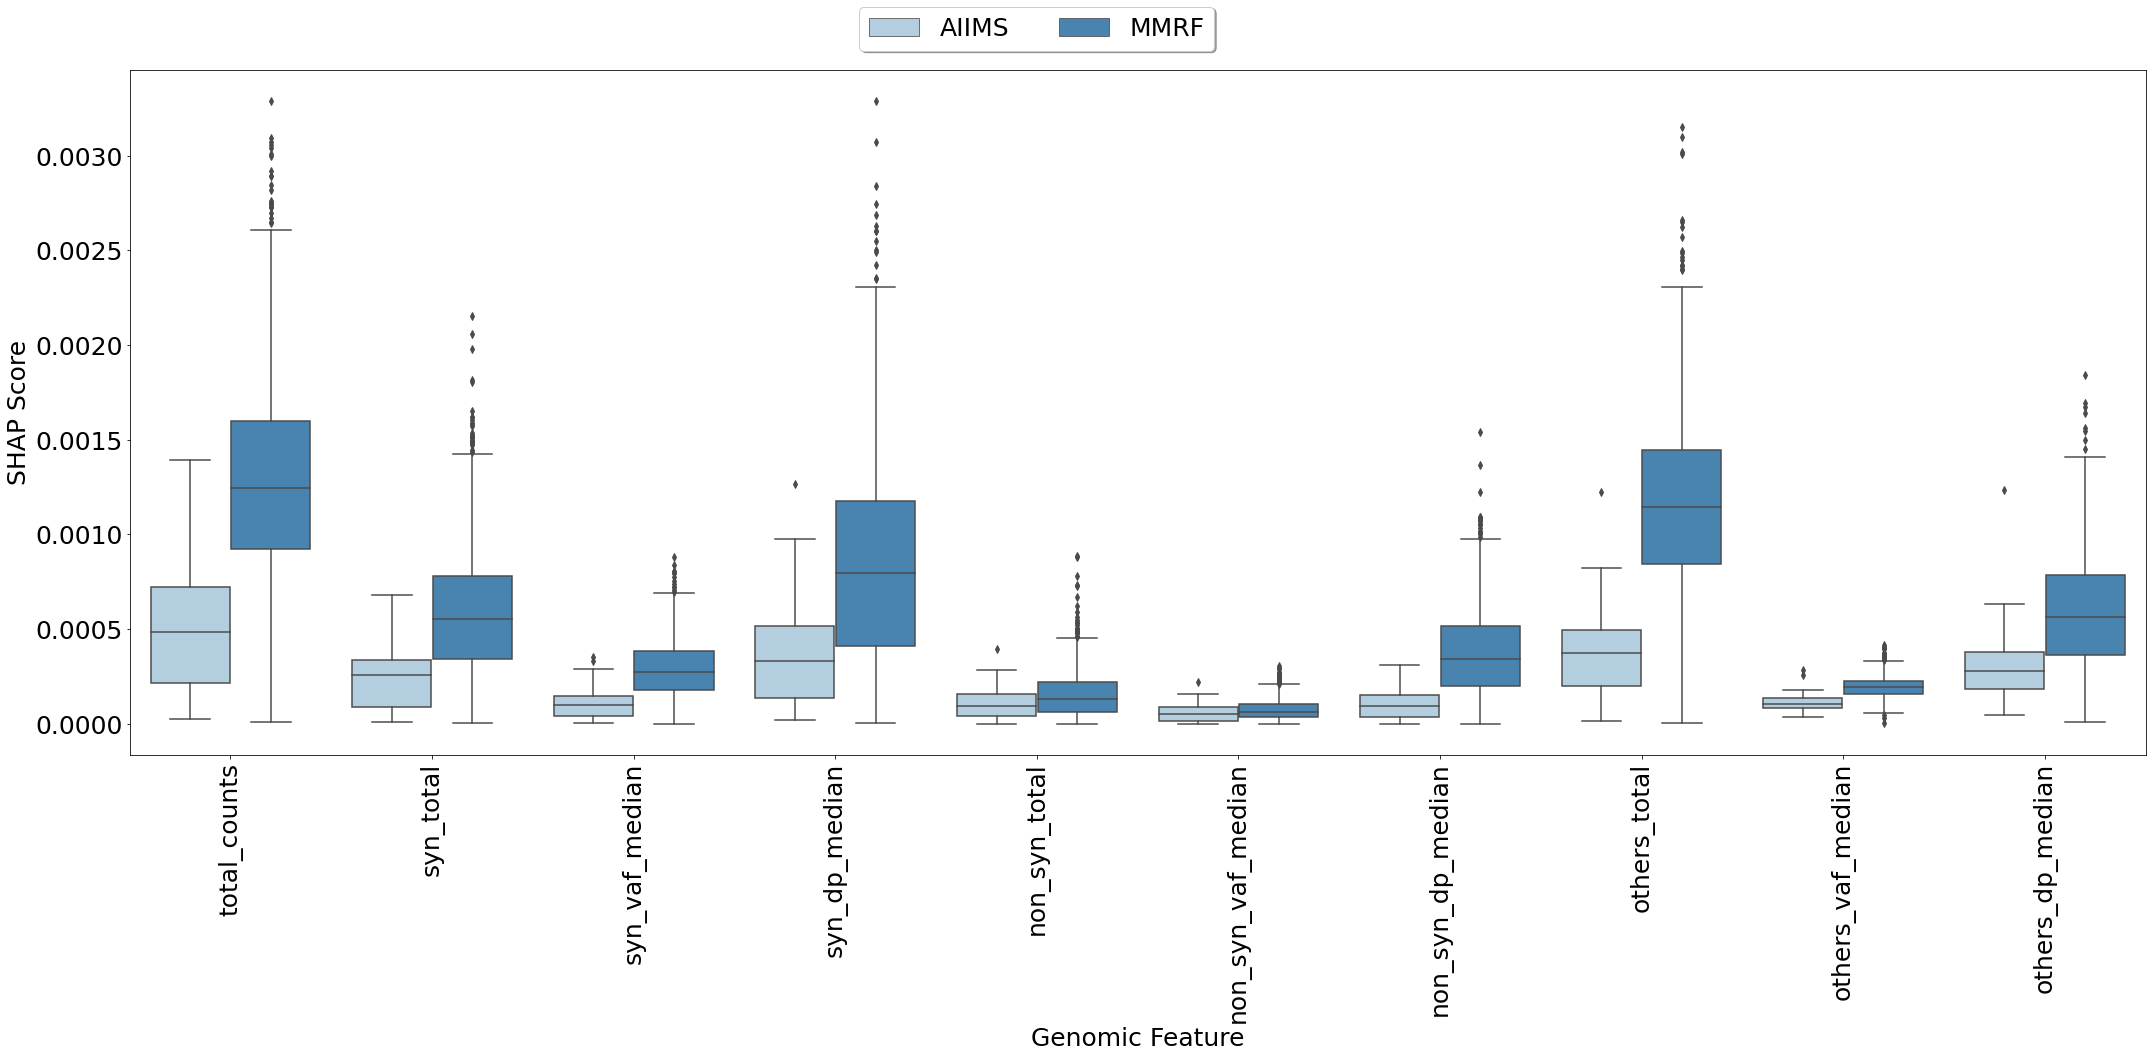

In [24]:
samplewise_feature_summary_mm = samplewise_feature_summary[samplewise_feature_summary['Disease'] == "MM"]
fig, ax = plt.subplots(figsize=(30,15))
sns.boxplot(x="feature_name", y="avg_shap", hue="Dataset", data=samplewise_feature_summary_mm, palette="Blues")
plt.xticks(rotation=90,fontsize=25)
plt.yticks(fontsize = 25)
plt.xlabel("Genomic Feature",fontsize = 25)
plt.ylabel("SHAP Score", fontsize = 25)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.11), ncol=3, fancybox=True, shadow=True,fontsize=25)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MM_samplewise_features_summary_v2.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MM_samplewise_features_summary_v2.svg",dpi=300)
plt.show()

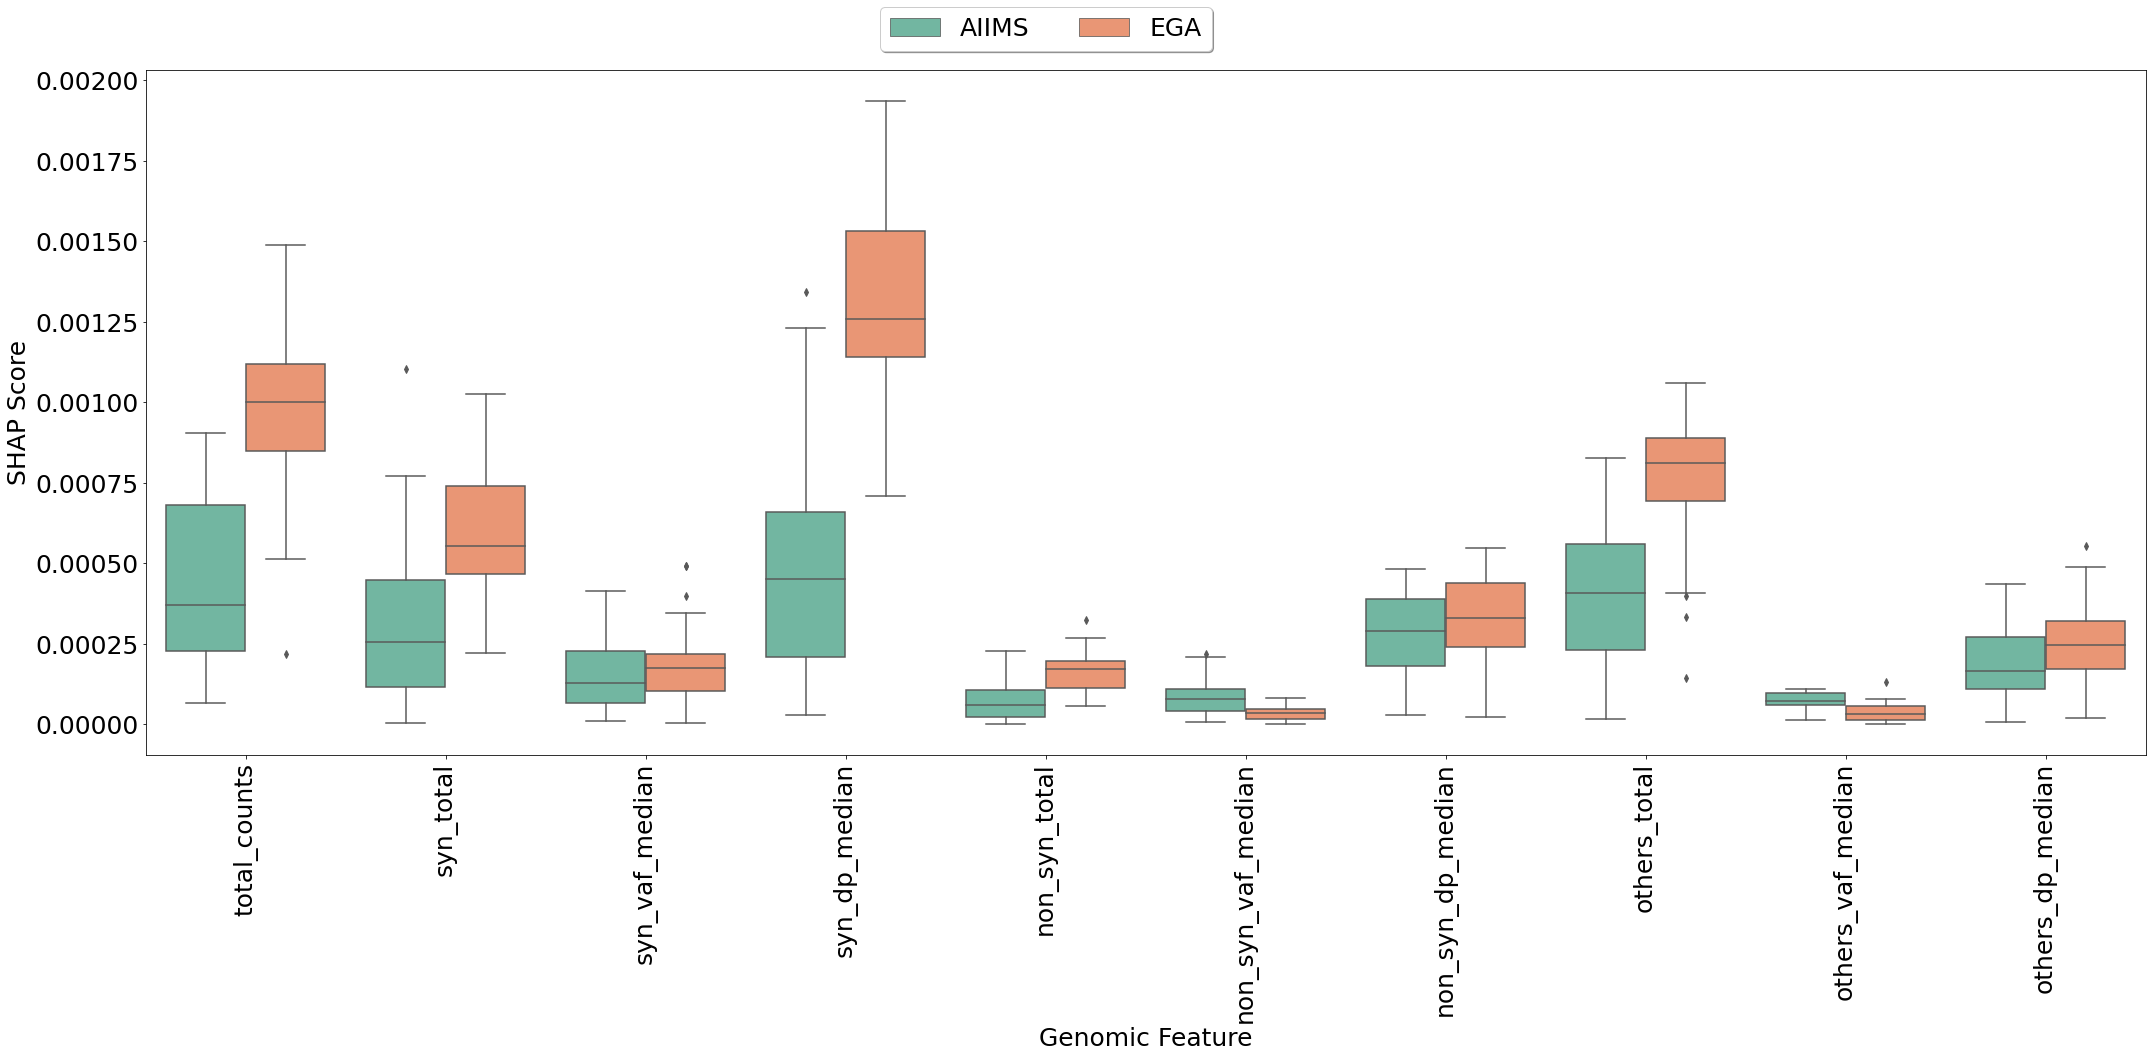

In [25]:
samplewise_feature_summary_mgus = samplewise_feature_summary[samplewise_feature_summary['Disease'] == "MGUS"]
fig, ax = plt.subplots(figsize=(30,15))
sns.boxplot(x="feature_name", y="avg_shap", hue="Dataset", data=samplewise_feature_summary_mgus, palette="Set2")
plt.xticks(rotation=90,fontsize=25)
plt.yticks(fontsize = 25)
plt.xlabel("Genomic Feature",fontsize = 25)
plt.ylabel("SHAP Score", fontsize = 25)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.11), ncol=3, fancybox=True, shadow=True,fontsize=25)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MGUS_samplewise_features_summary_v2.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/MGUS_samplewise_features_summary_v2.svg",dpi=300)
plt.show()

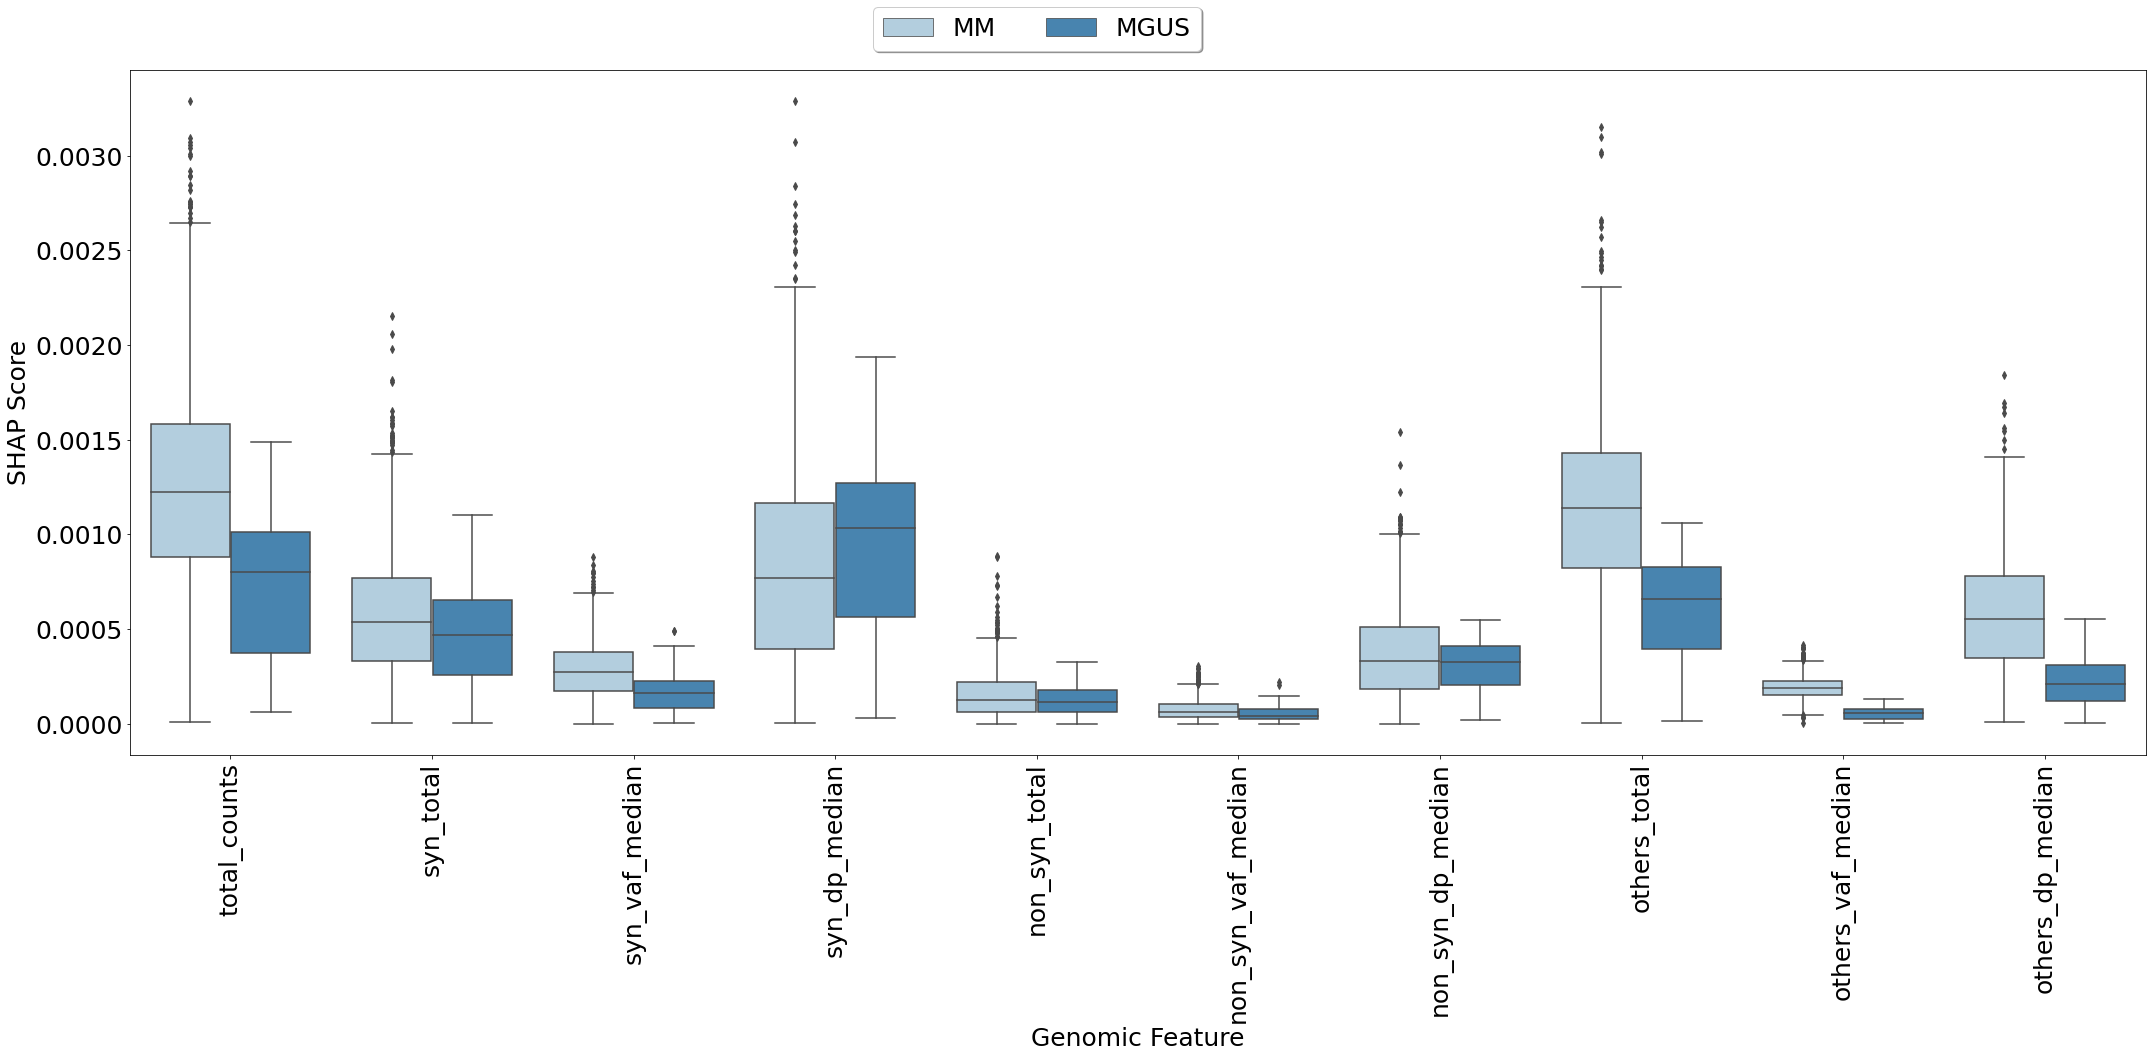

In [26]:
fig, ax = plt.subplots(figsize=(30,15))
sns.boxplot(x="feature_name", y="avg_shap", hue="Disease", data=samplewise_feature_summary, palette="Blues")
plt.xticks(rotation=90,fontsize=25)
plt.yticks(fontsize = 25)
plt.xlabel("Genomic Feature",fontsize = 25)
plt.ylabel("SHAP Score", fontsize = 25)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.11), ncol=3, fancybox=True, shadow=True,fontsize=25)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/both_MM_MGUS_samplewise_features_summary_v2.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/both_MM_MGUS_samplewise_features_summary_v2.svg",dpi=300)
plt.show()

In [27]:
samplewise_feature_summary = pd.DataFrame()
sample_list, dataset, feat_names, avg_shap = [], [], [], []
disease = []

for sam in tqdm(glob.glob("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/*.csv")):
    sam_name = sam.split('/')[-1].split('.')[0][:-14]
    if sam_name in mm_list_aiims or sam_name in mgus_list_aiims:
        df = get_shap_df(sam_name+'.csv')
        for f_idx in range(len(feature_list)):
            if 'total' in feature_list[f_idx] or 'median' in feature_list[f_idx]:
                if sam_name in total_mm_list:
                    disease.append("MM")
                else:
                    disease.append("MGUS")
                sample_list.append(sam_name)
                if sam_name in mm_list_aiims:
                    dataset.append("AIIMS(MM)")
                elif sam_name in mgus_list_aiims:
                    dataset.append("AIIMS(MGUS)")
                feat_names.append(feature_list[f_idx])
                avg_shap.append(df[feature_list[f_idx]].mean())
    
samplewise_feature_summary["Sample"] = sample_list
samplewise_feature_summary["Dataset"] = dataset
samplewise_feature_summary["Disease"] = disease
samplewise_feature_summary["feature_name"] = feat_names
samplewise_feature_summary["avg_shap"] = [np.abs(i) for i in avg_shap]
samplewise_feature_summary.to_excel("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/aiims_samplewise_features_summary.xlsx", index=False)
samplewise_feature_summary.head()

100%|██████████| 1163/1163 [00:05<00:00, 228.93it/s]


,Sample,Dataset,Disease,feature_name,avg_shap
0,SM0266,AIIMS(MM),MM,total_counts,0.000691
1,SM0266,AIIMS(MM),MM,syn_total,0.000383
2,SM0266,AIIMS(MM),MM,syn_vaf_median,0.000288
3,SM0266,AIIMS(MM),MM,syn_dp_median,0.000373
4,SM0266,AIIMS(MM),MM,non_syn_total,0.000153


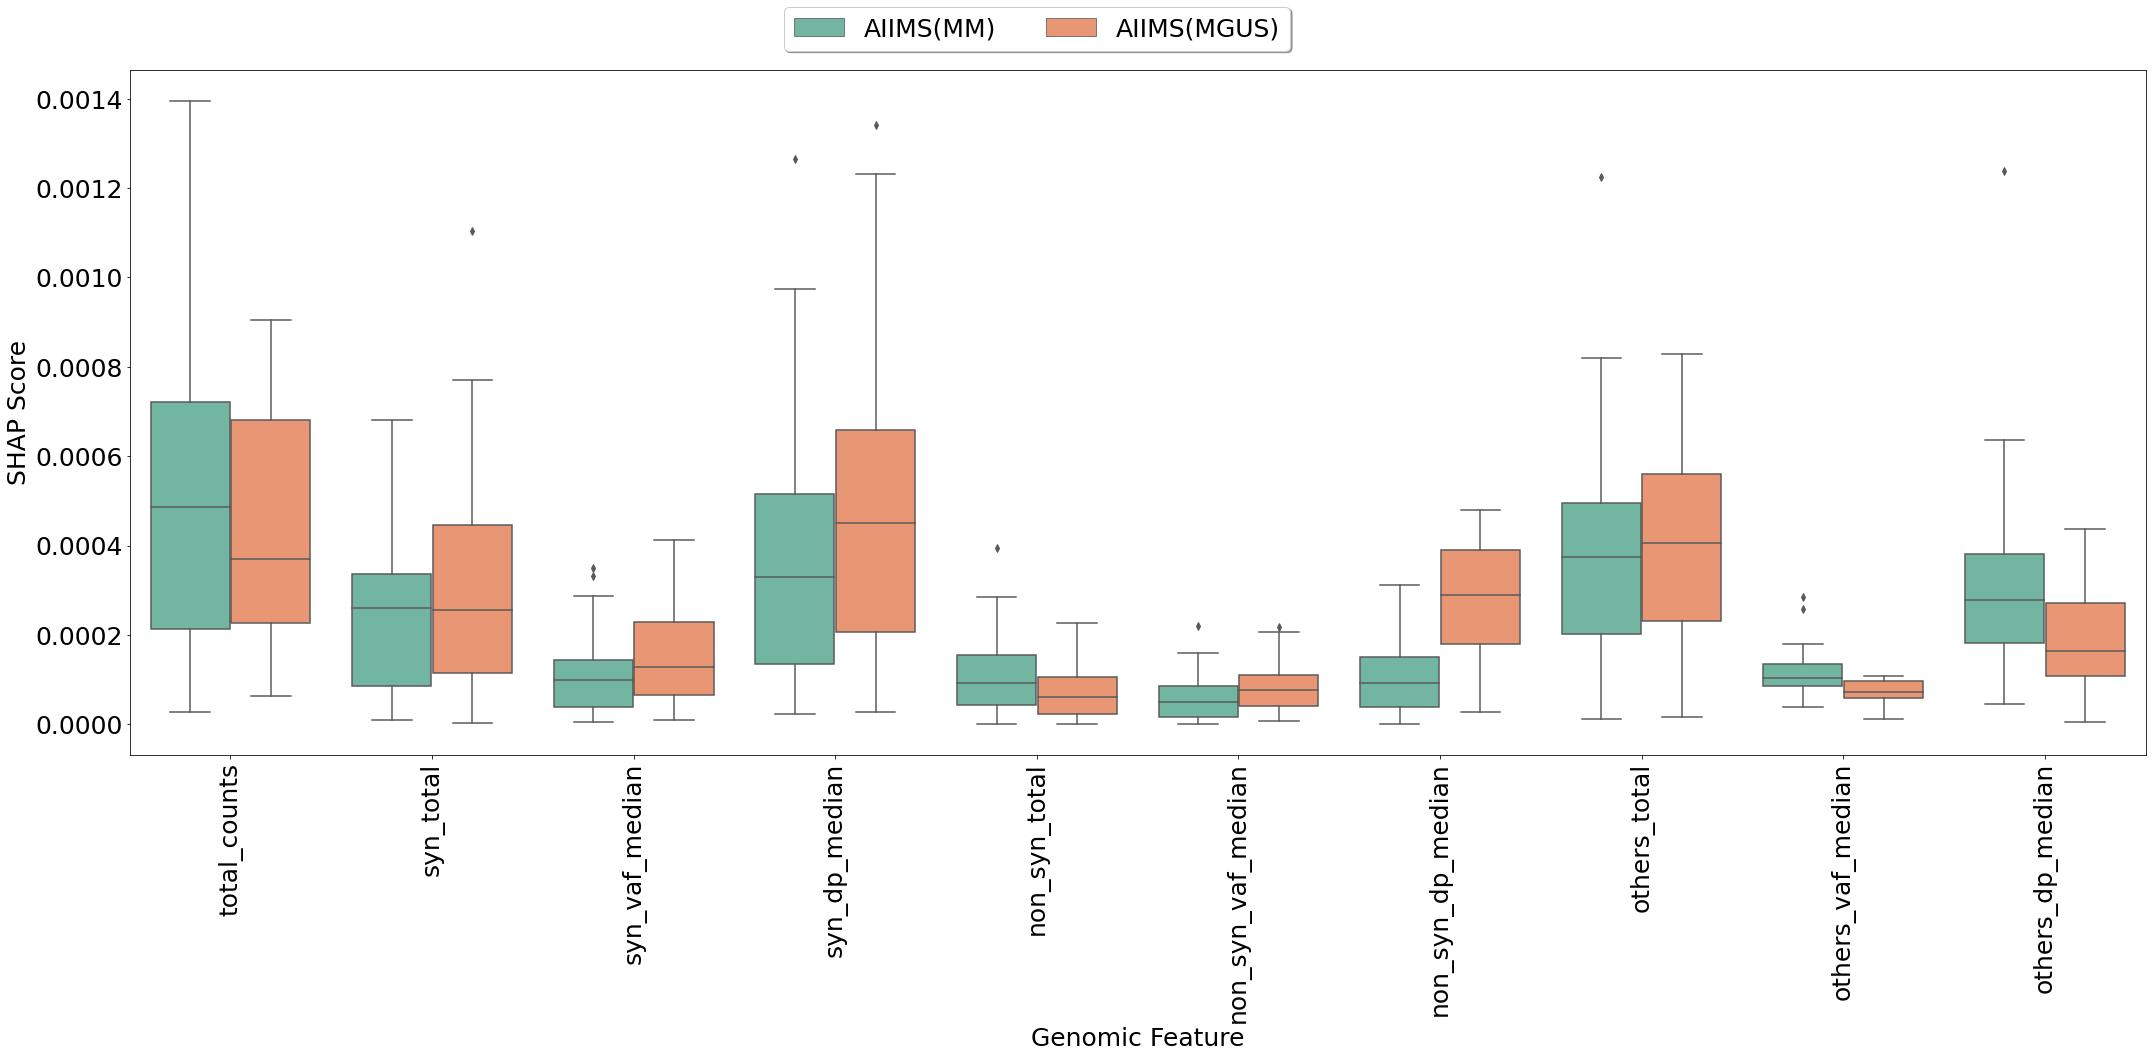

In [28]:
fig, ax = plt.subplots(figsize=(30,15))
sns.boxplot(x="feature_name", y="avg_shap", hue="Dataset", data=samplewise_feature_summary, palette="Set2")
plt.xticks(rotation=90,fontsize=25)
plt.yticks(fontsize = 25)
plt.xlabel("Genomic Feature",fontsize = 25)
plt.ylabel("SHAP Score", fontsize = 25)
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.11), ncol=3, fancybox=True, shadow=True,fontsize=25)
plt.tight_layout()
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/aiims_MGUS_samplewise_features_summary.png",dpi=300)
plt.savefig("/home/vivek/jupyter_notebooks/GCN_model/Feb_25_2022/sample_specific_analysis/others/aiims_MGUS_samplewise_features_summary.svg",dpi=300)
plt.show()